In [1]:
%load_ext autoreload
%autoreload 2

# Self-Supervised Learning

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/convnets/blob/master/learn/04_self_supervised_learning.ipynb)

As we saw in the previous notebook, using pre-trained convnets gives us better data efficiency. In our example we were able to go from a 15% error rate to a 5% error rate, which is a 66% improvement, by leveragin the pre-trained weights on the Imagenet dataset, which is very different from satellite imagery. The problem is that there is no imagenet-like dataset for satellite imagery, nor pre-trained models on this data types (which is a common problem in many real world applications). However, we have available large datasets of unlabeled satellite images, so our objective will be to pre-train a convnet on unlabeled data (closer to our problem) in a self-supervised way, and then use it to fine-tune a model on our labeled data to obtain even better results.

In this example we are going to pre-train a resnet18 on the [SeCo](https://github.com/ServiceNow/seasonal-contrast) 100k RGB variant dataset using the [Barlow Twins](https://arxiv.org/abs/2103.03230) framework (you can use the 1M variant to obtain even better data efficiency).

In [2]:
from convnets.datasets import SeCo 

seco = SeCo()

In [3]:
seco.data

,image
0,/fastdata/seasonal_contrast_100k/004556/202007...
1,/fastdata/seasonal_contrast_100k/004556/201911...
2,/fastdata/seasonal_contrast_100k/004556/202004...
3,/fastdata/seasonal_contrast_100k/004556/202009...
4,/fastdata/seasonal_contrast_100k/004556/202001...
...,...
99995,/fastdata/seasonal_contrast_100k/013355/201907...
99996,/fastdata/seasonal_contrast_100k/013355/201909...
99997,/fastdata/seasonal_contrast_100k/013355/202005...
99998,/fastdata/seasonal_contrast_100k/013355/202003...


In [4]:
from convnets.datasets import SSLDataset 
import albumentations as A

dataset = SSLDataset(seco.data.image.values, trans=A.Compose([
    A.RandomResizedCrop(224, 224, scale=(0.5, 1.0), p=1),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.ToGray(p=0.3),
    A.GaussianBlur(p=0.3),
    # A.Solarize(p=0.3)
]))

len(dataset)

100000

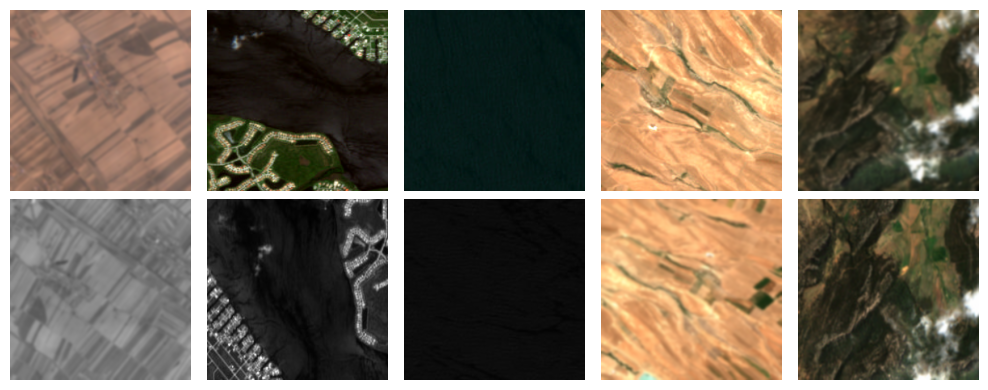

In [5]:
import random
import matplotlib.pyplot as plt
from einops import rearrange

r, c = 2, 5
plt.figure(figsize=(c*2, r*2))
for col in range(c):
    plt.subplot(r, c, col + 1)
    ix = random.randint(0, len(dataset)-1)
    im1, im2 = dataset[ix]
    plt.imshow(rearrange(im1, 'c h w -> h w c'))
    plt.axis('off')
    plt.subplot(r, c, c + col + 1)
    plt.imshow(rearrange(im2, 'c h w -> h w c'))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
import torchvision
from convnets.models import BarlowTwins
import torch
from convnets.train import barlow_fit 

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)

backbone = torch.nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
model = BarlowTwins(backbone)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, pct_start=0.03, max_lr=1e-3, total_steps=100, verbose=True)

# hist = barlow_fit(model, dataloader, optimizer, scheduler, epochs=100)

/home/juan/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Adjusting learning rate of group 0 to 4.0000e-05.


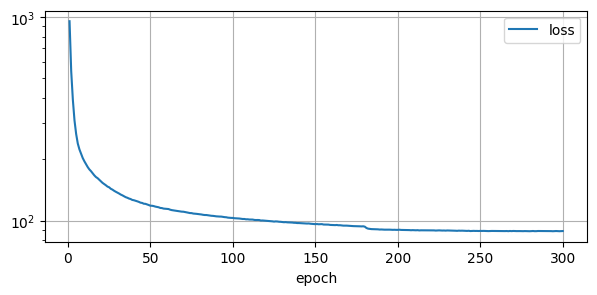

In [10]:
import pandas as pd 

df = pd.read_csv('barlow.csv')
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 1, 1)
df.plot(x='epoch', y='loss', ax = ax, logy=True)
ax.grid(True)
plt.show()

After training (it will take a while) we can load the model and use it for fine-tuning on our labeled dataset. Differences are even more dramatic when we use a small dataset for fine-tuning.

In [11]:
from convnets.datasets import EuroSAT
from convnets.datasets import ImageClassificationDataset 
from convnets.train import fit 
import pandas as pd
import torch
from torch.utils.data import DataLoader
from convnets.train import seed_everything
import json

In [23]:
label_ratios = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
EPOCHS = 50

# hists = {}
with open('hists.json', 'r') as f:
	hists = json.load(f)
        
for label_ratio in label_ratios:
    # hists[label_ratio] = {}
    seed_everything()

    data = EuroSAT(label_ratio=label_ratio)

    dataset = {
        'train': ImageClassificationDataset(data.train.image.values, data.train.label.values),
        'val': ImageClassificationDataset(data.test.image.values, data.test.label.values),
    }

    dataloaders  =  {
        'train': DataLoader(dataset['train'], batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
        'val': DataLoader(dataset['val'], batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
    }

    # train from scratch 
    # print(f'train from scratch with label ratio {label_ratio}')
    # model = torchvision.models.resnet18(weights=None)
    # model.fc = torch.nn.Linear(model.fc.in_features, data.num_classes)
    # optimizer = torch.optim.Adam(model.parameters())
    criterion = torch.nn.CrossEntropyLoss()
    # hists[label_ratio]['scratch'] = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=EPOCHS)

    # transfer learning 
    # print(f'transfer learning with label ratio {label_ratio}')
    # model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    # # we freeze the weights of the pretrained model so they don't get updated
    # for param in model.parameters():
    #     param.requires_grad = False
    # model.fc = torch.nn.Linear(model.fc.in_features, data.num_classes)
    # optimizer = torch.optim.Adam(model.parameters())
    # hists[label_ratio]['tl'] = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=EPOCHS)

    # # fine tuning
    # print(f'fine tuning with label ratio {label_ratio}')
    # model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    # model.fc = torch.nn.Linear(model.fc.in_features, 10)
    # optimizer = torch.optim.Adam(model.parameters())
    # hists[label_ratio]['ft'] = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=EPOCHS)

    # ssl transfer learning
    print(f'ssl transfer learning with label ratio {label_ratio}')
    model = BarlowTwins(backbone)
    model.load_state_dict(torch.load('./checkpoints/barlow.pth'))
    model.head = torch.nn.Linear(512, data.num_classes)
    # freeze backbone
    for param in model.backbone.parameters():
        param.requires_grad = False
    optimizer = torch.optim.Adam(model.parameters())
    hists[label_ratio]['ssl (tl)'] = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=EPOCHS)

    # ssl fine tuning
    print(f'ssl fine tuning with label ratio {label_ratio}')
    model = BarlowTwins(backbone)
    model.load_state_dict(torch.load('./checkpoints/barlow.pth'))
    model.head = torch.nn.Linear(512, data.num_classes)
    optimizer = torch.optim.Adam(model.parameters())
    hists[label_ratio]['ssl (ft)'] = fit(model, dataloaders, optimizer, criterion, 'cuda', log=False, epochs=EPOCHS)

# save hists as json
with open('hists.json', 'w') as f:
    json.dump(hists, f)

data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400
training samples after label ratio filtering: 216
train from scratch with label ratio 0.01
Training model on cuda


transfer learning with label ratio 0.01
Training model on cuda


fine tuning with label ratio 0.01
Training model on cuda


ssl transfer learning with label ratio 0.01
Training model on cuda


ssl fine tuning with label ratio 0.01
Training model on cuda


data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400
training samples after label ratio filtering: 432
train from scratch with label ratio 0.02
Training model on cuda


transfer learning with label ratio 0.02
Training model on cuda


fine tuning with label ratio 0.02
Training model on cuda


ssl transfer learning with label ratio 0.02
Training model on cuda


ssl fine tuning with label ratio 0.02
Training model on cuda


data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400
training samples after label ratio filtering: 1080
train from scratch with label ratio 0.05
Training model on cuda


transfer learning with label ratio 0.05
Training model on cuda


fine tuning with label ratio 0.05
Training model on cuda


ssl transfer learning with label ratio 0.05
Training model on cuda


ssl fine tuning with label ratio 0.05
Training model on cuda


data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400
training samples after label ratio filtering: 2160
train from scratch with label ratio 0.1
Training model on cuda


transfer learning with label ratio 0.1
Training model on cuda


fine tuning with label ratio 0.1
Training model on cuda


ssl transfer learning with label ratio 0.1
Training model on cuda


ssl fine tuning with label ratio 0.1
Training model on cuda


data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400
training samples after label ratio filtering: 4320
train from scratch with label ratio 0.2
Training model on cuda


transfer learning with label ratio 0.2
Training model on cuda


fine tuning with label ratio 0.2
Training model on cuda


ssl transfer learning with label ratio 0.2
Training model on cuda


ssl fine tuning with label ratio 0.2
Training model on cuda


data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400
training samples after label ratio filtering: 10800
train from scratch with label ratio 0.5
Training model on cuda


transfer learning with label ratio 0.5
Training model on cuda


fine tuning with label ratio 0.5
Training model on cuda


ssl transfer learning with label ratio 0.5
Training model on cuda


ssl fine tuning with label ratio 0.5
Training model on cuda


data already downloaded and extracted !
Number of images: 27000
Training samples 21600
Test samples 5400
train from scratch with label ratio 1
Training model on cuda


transfer learning with label ratio 1
Training model on cuda


fine tuning with label ratio 1
Training model on cuda


ssl transfer learning with label ratio 1
Training model on cuda


ssl fine tuning with label ratio 1
Training model on cuda


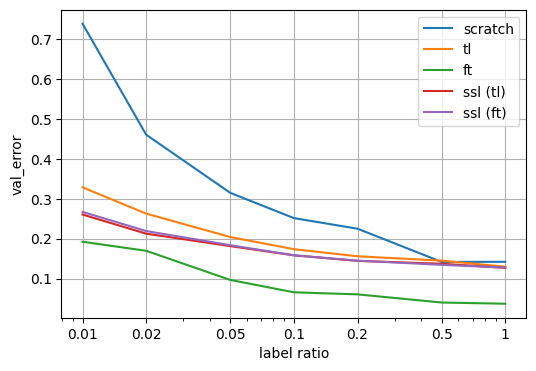

In [24]:
with open('hists.json', 'r') as f:
	hists = json.load(f)

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(1, 1, 1)
lines = {}
for ix, label_ratio in enumerate(label_ratios):
	label_ratio = str(label_ratio)
	for k, v in hists[label_ratio].items():
		df = pd.DataFrame(v)
		if k not in lines:
			lines[k] = []
		lines[k].append(min(df['val_error'].values))

df = pd.DataFrame(lines, index=label_ratios)
df.plot(ax=ax, grid=True, logx=True, xticks=label_ratios, xlabel='label ratio', ylabel='val_error')
ax.set_xticklabels(label_ratios)
plt.show()

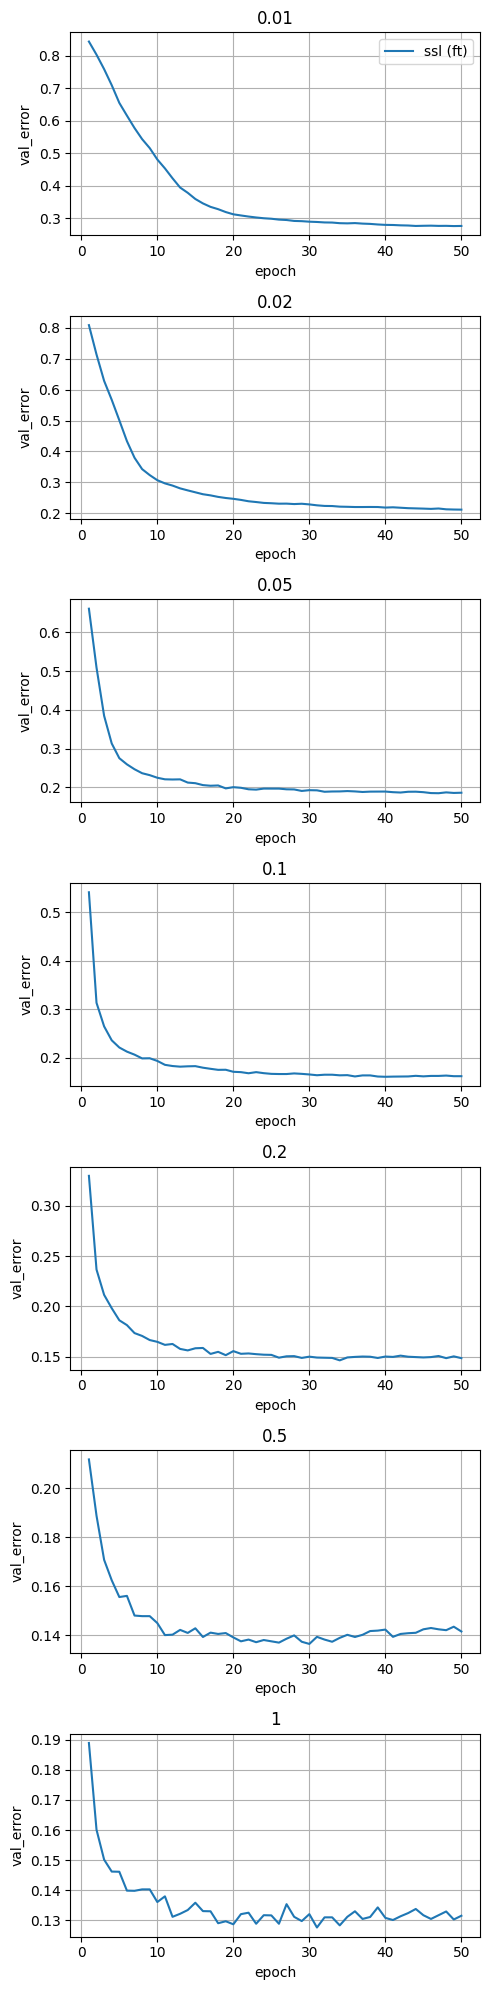

In [22]:
fig = plt.figure(figsize=(5,20))
for ix, label_ratio in enumerate(label_ratios):
	ax = plt.subplot(len(label_ratios), 1, ix + 1)
	label_ratio = str(label_ratio)
	for k, v in hists[label_ratio].items():
		df = pd.DataFrame(v)
		df.plot(x='epoch', y='val_error', ax = ax, label=k)
	ax.grid(True)
	ax.set_ylabel('val_error')
	ax.set_title(label_ratio)
	if ix != 0:
		ax.legend().remove()
plt.tight_layout()
plt.show()